In [174]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
with open("SRInPressure.json") as datafile:
    data = json.load(datafile, encoding='utf-8')
dataset = pd.DataFrame(data)

dataset.set_index('dateTimeValues', inplace=True)
dataset['timeSeries'] = dataset['timeSeries'].apply(pd.to_numeric).astype(float)
dataset.drop(dataset.columns[[0,1]], inplace=True, axis=1)
#dataset.drop(dataset.columns[[1, 2]])


dataset.head()

,timeSeries
dateTimeValues,
2013-12-30 00:00:00,0.104970
2013-12-30 00:15:00,0.104360
2013-12-30 00:30:00,0.143093
2013-12-30 00:45:00,0.109712
2013-12-30 01:00:00,0.112431


In [176]:
dataset.index=pd.to_datetime(dataset.index)

dataset.head(10)

,timeSeries
dateTimeValues,
2013-12-30 00:00:00,0.104970
2013-12-30 00:15:00,0.104360
2013-12-30 00:30:00,0.143093
2013-12-30 00:45:00,0.109712
2013-12-30 01:00:00,0.112431
2013-12-30 01:15:00,0.131946
2013-12-30 01:30:00,0.110707
2013-12-30 01:45:00,0.133236
2013-12-30 02:00:00,0.126729


In [177]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [178]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,high=len(training_data)-steps)

    # Create Y data for time series in the batches
    data = np.array(train_set[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return data[:, :-1].reshape(-1, steps, 1), data[:, 1:].reshape(-1, steps, 1) 

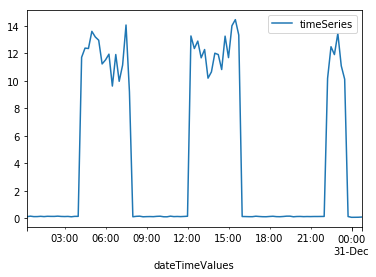

In [179]:
#train_set, test_set = split_train_test(dataset, 0.2)
#print(len(train_set), "train +", len(test_set), "test")



train_set = dataset[0:34944]
test_set= dataset[34945:35244]
train_set.head()
adg = train_set[1:100]

adg.plot()

In [180]:
#print(train_set)

In [181]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#train_set.shape
train_scaled = train_set.values#scaler.fit_transform(train_set)
#train_scaled = scaler.transform(train_set)


In [182]:
print(train_scaled)

[[  0.10496966]
 [  0.10436031]
 [  0.14309299]
 ..., 
 [  9.73228601]
 [ 12.7609053 ]
 [  0.1536736 ]]


In [183]:
'''tf.app.flags.DEFINE_integer('model_version', 1, 'version number of the model.')
tf.app.flags.DEFINE_string('work_dir', '', 'Working directory.')
FLAGS = tf.app.flags.FLAGS'''

"tf.app.flags.DEFINE_integer('model_version', 1, 'version number of the model.')\ntf.app.flags.DEFINE_string('work_dir', '', 'Working directory.')\nFLAGS = tf.app.flags.FLAGS"

In [195]:
import tensorflow as tf
tf.reset_default_graph()

# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 672#97#336#672
# 100 neuron layer, play with this
num_neurons = 200#300 #200
# Just one outpt, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.0001 #0.001 #0.0005

# how many iterations to go through (training steps), you can play with this
num_train_iterations = 75000
# Size of the batch of data
batch_size = 1


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])
#train_set=train_set.reshape(-1,num_time_steps,1)


cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=num_neurons, dropout_keep_prob=0.7,activation=tf.nn.relu),
    output_size=num_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32,parallel_iterations=256)
outputs.get_shape()
#states.get_shape()

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,momentum=0.5,centered=True,decay=0.2)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)



In [205]:
#train_set.plot()

In [196]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration, "\tMSE:", mse)
            
        '''
    print('Done training!')
    # Export model
    export_path_base = FLAGS.work_dir
    export_path = os.path.join(
        tf.compat.as_bytes(export_path_base),
        tf.compat.as_bytes(str(FLAGS.model_version)))
    print('Exporting trained model to', export_path)
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(outputs)

    prediction_signature = (
        tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'input': tensor_info_x},
          outputs={'output': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
    builder.add_meta_graph_and_variables(
        sess, [tf.saved_model.tag_constants.SERVING],
        signature_def_map={
          'prediction':
              prediction_signature,
      },
      legacy_init_op=legacy_init_op)

    builder.save()

    print('Done exporting!')'''

      
    # Save Model for Later
    #saver.save(sess, "/home/infd-003/sequence_model_poc/LayerNormBasicLSTMCell/LayerNormBasicLSTMCell.ckpt")
    saver.save(sess, "/home/ml/sequence_modeling/LayerNormBasicLSTMCell/LayerNormBasicLSTMCell.ckpt")
   

0 	MSE: 51.6014
100 	MSE: 8.00823
200 	MSE: 4.67645
300 	MSE: 4.06296
400 	MSE: 4.32211
500 	MSE: 3.81438
600 	MSE: 3.9351
700 	MSE: 3.18226
800 	MSE: 3.93867
900 	MSE: 2.97809
1000 	MSE: 2.78918
1100 	MSE: 2.6522
1200 	MSE: 2.16409
1300 	MSE: 2.08482
1400 	MSE: 3.37809
1500 	MSE: 1.95956
1600 	MSE: 1.45005
1700 	MSE: 1.90431
1800 	MSE: 1.72008
1900 	MSE: 1.50036
2000 	MSE: 1.97422
2100 	MSE: 1.09923
2200 	MSE: 1.64336
2300 	MSE: 2.28761
2400 	MSE: 1.40547
2500 	MSE: 1.40224
2600 	MSE: 1.14284
2700 	MSE: 1.42187
2800 	MSE: 1.42017
2900 	MSE: 1.08331
3000 	MSE: 1.29307
3100 	MSE: 1.10527
3200 	MSE: 1.10503
3300 	MSE: 1.20302
3400 	MSE: 1.01015
3500 	MSE: 1.27329
3600 	MSE: 1.08621
3700 	MSE: 1.41502
3800 	MSE: 1.28314
3900 	MSE: 1.32902
4000 	MSE: 1.17478
4100 	MSE: 1.15322
4200 	MSE: 1.23114
4300 	MSE: 0.953289
4400 	MSE: 1.36559
4500 	MSE: 1.12829
4600 	MSE: 1.28407
4700 	MSE: 1.1401
4800 	MSE: 0.928805
4900 	MSE: 1.03247
5000 	MSE: 1.23941
5100 	MSE: 1.36054
5200 	MSE: 1.02573
5300 	

41100 	MSE: 0.93642
41200 	MSE: 1.07317
41300 	MSE: 1.06363
41400 	MSE: 0.886632
41500 	MSE: 1.19268
41600 	MSE: 0.920776
41700 	MSE: 1.06641
41800 	MSE: 1.05537
41900 	MSE: 1.25811
42000 	MSE: 1.06623
42100 	MSE: 0.931101
42200 	MSE: 0.944112
42300 	MSE: 0.889602
42400 	MSE: 1.06673
42500 	MSE: 0.909701
42600 	MSE: 1.05842
42700 	MSE: 0.99519
42800 	MSE: 1.24615
42900 	MSE: 0.944185
43000 	MSE: 1.0349
43100 	MSE: 1.00875
43200 	MSE: 0.924542
43300 	MSE: 0.994285
43400 	MSE: 1.01472
43500 	MSE: 0.938961
43600 	MSE: 0.766759
43700 	MSE: 0.927745
43800 	MSE: 0.994954
43900 	MSE: 1.04447
44000 	MSE: 1.068
44100 	MSE: 1.02336
44200 	MSE: 0.9966
44300 	MSE: 1.02939
44400 	MSE: 0.96498
44500 	MSE: 1.10167
44600 	MSE: 0.925644
44700 	MSE: 0.903219
44800 	MSE: 0.897225
44900 	MSE: 1.07166
45000 	MSE: 1.05892
45100 	MSE: 0.864623
45200 	MSE: 1.05608
45300 	MSE: 1.02642
45400 	MSE: 1.10934
45500 	MSE: 0.978016
45600 	MSE: 0.943073
45700 	MSE: 1.15501
45800 	MSE: 0.885902
45900 	MSE: 1.22877
4600

In [50]:
#print(X_batch)
#train_seed = list(train_scaled[-num_time_steps:])
#print(train_seed)

[array([ 0.00987343]), array([ 0.0109391]), array([ 0.00978999]), array([ 0.00807556]), array([ 0.0092541]), array([ 0.00849877]), array([ 0.00911174]), array([ 0.01160474]), array([ 0.01163104]), array([ 0.00805559]), array([ 0.01011014]), array([ 0.0078994]), array([ 0.00864434]), array([ 0.00834776]), array([ 0.00896563]), array([ 0.00875865]), array([ 0.00872612]), array([ 0.00872372]), array([ 0.84568587]), array([ 0.76043335]), array([ 0.63355579]), array([ 0.87238695]), array([ 0.67768411]), array([ 0.83594483]), array([ 0.81953521]), array([ 0.93028627]), array([ 0.69325511]), array([ 0.86575025]), array([ 0.73251707]), array([ 0.66348754]), array([ 0.77102852]), array([ 0.80591975]), array([ 0.61598598]), array([ 0.00901298]), array([ 0.00866356]), array([ 0.01123618]), array([ 0.01104209]), array([ 0.00871637]), array([ 0.01050051]), array([ 0.01070598]), array([ 0.00947408]), array([ 0.01075614]), array([ 0.01052441]), array([ 0.00785384]), array([ 0.00865803]), array([ 0.00

In [197]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    #saver.restore(sess, "/home/infd-003/sequence_model_poc/model_saved/ex_time_series_model1.ckpt")
    saver.restore(sess, "/home/ml/sequence_modeling/LayerNormBasicLSTMCell/LayerNormBasicLSTMCell.ckpt")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-num_time_steps:])
    
    ## Now create a for loop that 
    for iteration in range(100):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(-1, num_time_steps, 1)
        #print("********X_batch", X_batch,"***********")
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        #print("********y_pred", y_pred,"***********")
        #y_pred = y_pred[25:125]
        train_seed.append(y_pred[0, -1, 0])
        #print("********train_seed", X_batch,"***********")

INFO:tensorflow:Restoring parameters from /home/ml/sequence_modeling/LayerNormBasicLSTMCell/LayerNormBasicLSTMCell.ckpt


In [188]:
#print(y_pred)

In [198]:
len(train_seed[num_time_steps:])

100

In [170]:
#print(train_seed)

In [199]:
results = np.array(train_seed[num_time_steps:]).reshape(100,1)
#results = scaler.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(200,1))
#print(results)

In [200]:
new_test_set = test_set.head(100)


In [201]:
new_test_set['predicted'] = results

/home/ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [172]:
#a = [[1],[2],[3],[4],[0],[5],[6],[7],[8],[9]]
#b = a[0,-1,0]

In [21]:
#print(new_test_set)

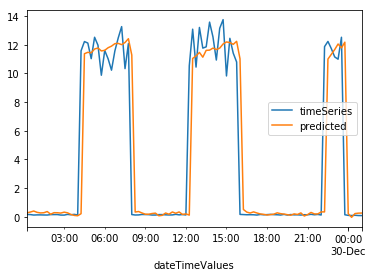

In [202]:
new_test_set.plot()